## Импорт необходимых библиотек

* requests: используется для выполнения HTTP-запросов, чтобы получить данные из API.
* numpy: библиотека для работы с массивами и матрицами.
* pandas: библиотека для работы с табличными данными, предоставляет структуры данных и операции для манипуляции таблицами.
* sklearn.preprocessing.MinMaxScaler: для нормализации данных.
* sklearn.model_selection.train_test_split: для разделения данных на обучающую и тестовую выборки.
* sklearn.metrics: для оценки качества моделей (MAE, MSE, R²).
* tensorflow.keras: для построения и работы с нейронными сетями.
* plotly.graph_objects: для визуализации данных.
* joblib: для сериализации объектов Python.

## Функция для загрузки данных

```
def download_data(api_url, params):
    response = requests.get(api_url, params=params)
    data = response.json()
    return pd.DataFrame(data)
```
Эта функция делает HTTP GET запрос к заданному URL с параметрами и возвращает полученные данные в виде DataFrame.

## Задание параметров API 

```
api_url = 'https://api.binance.com/api/v3/klines'
params = {
    'symbol': 'BTCUSDT',
    'interval': '1h',
    'limit': 10000
}
```
* api_url: URL для API Binance, который предоставляет данные о криптовалютных рынках.
* params: параметры запроса:
* symbol: торгуемая пара (BTC к USDT).
* interval: временной интервал для каждой свечи (1 час).
* limit: количество свечей для запроса (10000).

##  Загрузка и обработка данных

1. file_path = 'data/BIN3.csv'
2. new_data = download_data(api_url, params)
3. new_data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
4. new_data['time'] = pd.to_datetime(new_data['time'], unit='ms')


In [269]:
import requests
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import joblib
from datetime import datetime, timedelta


# def download_data(api_url, params):
#     response = requests.get(api_url, params=params)
#     data = response.json()
#     return pd.DataFrame(data)


# api_url = 'https://api.binance.com/api/v3/klines'
# params = {
#     'symbol': 'BTCUSDT',
#     'interval': '1h',
#     'limit': 10000
# }

# file_path = 'data/BIN3.csv'
# new_data = download_data(api_url, params)
# new_data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
# new_data['time'] = pd.to_datetime(new_data['time'], unit='ms')

def download_data(api_url, symbol, interval, start_date, end_date, limit=1000):
    all_data = []
    start_timestamp = int(start_date.timestamp() * 1000)
    end_timestamp = int((end_date + timedelta(days=1)).timestamp() * 1000)

    while start_timestamp < end_timestamp:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_timestamp,
            'endTime': end_timestamp,
            'limit': limit
        }
        response = requests.get(api_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            start_timestamp = data[-1][0] + 1  # Move to the next time interval
        else:
            print(f"Error: {response.status_code}, {response.text}")
            break
    
    return pd.DataFrame(all_data)

# Пример использования
api_url = 'https://api.binance.com/api/v3/klines'
symbol = 'BTCUSDT'
interval = '1h'
start_date = datetime(2022, 6, 17)
end_date = datetime(2024, 6, 17)

new_data = download_data(api_url, symbol, interval, start_date, end_date)
if not new_data.empty:
    new_data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    new_data['time'] = pd.to_datetime(new_data['time'], unit='ms')
    print(new_data.head())
else:
    print("Failed to retrieve data.")

                 time            open            high             low  \
0 2022-06-16 21:00:00  20712.58000000  20932.00000000  20631.01000000   
1 2022-06-16 22:00:00  20685.50000000  20707.78000000  20343.22000000   
2 2022-06-16 23:00:00  20364.98000000  20492.52000000  20232.00000000   
3 2022-06-17 00:00:00  20400.60000000  20630.00000000  20246.66000000   
4 2022-06-17 01:00:00  20363.64000000  20949.20000000  20347.03000000   

            close         volume     close_time  quote_asset_volume  \
0  20685.50000000  2035.35819000  1655416799999   42322610.12101430   
1  20364.99000000  4621.68329000  1655420399999   94919327.15101270   
2  20401.31000000  5823.46631000  1655423999999  118344399.35219930   
3  20363.63000000  4725.47209000  1655427599999   96426152.18654510   
4  20880.80000000  6104.53991000  1655431199999  125930736.93956910   

   number_of_trades taker_buy_base_asset_volume taker_buy_quote_asset_volume  \
0             49600               1049.33379000       

## Анализ структуры загруженного DataFrame

In [270]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17563 entries, 0 to 17562
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   time                          17563 non-null  datetime64[ns]
 1   open                          17563 non-null  object        
 2   high                          17563 non-null  object        
 3   low                           17563 non-null  object        
 4   close                         17563 non-null  object        
 5   volume                        17563 non-null  object        
 6   close_time                    17563 non-null  int64         
 7   quote_asset_volume            17563 non-null  object        
 8   number_of_trades              17563 non-null  int64         
 9   taker_buy_base_asset_volume   17563 non-null  object        
 10  taker_buy_quote_asset_volume  17563 non-null  object        
 11  ignore                      

Подробное описание структуры DataFrame:
* Index: DataFrame имеет RangeIndex с 1000 строками, пронумерованными от 0 до 999.
* Columns: Всего 12 столбцов.
Столбцы и их типы данных:
1. time: 1000 ненулевых значений, тип данных - datetime64[ns].
    * Время открытия свечи.
2. open: 1000 ненулевых значений, тип данных - object.
    * Цена открытия свечи.
3. high: 1000 ненулевых значений, тип данных - object.
    * Наибольшая цена свечи.
4. low: 1000 ненулевых значений, тип данных - object.
    * Наименьшая цена свечи.
5. close: 1000 ненулевых значений, тип данных - object.
    * Цена закрытия свечи.
6. volume: 1000 ненулевых значений, тип данных - object.
    * Объем торгов.
7. close_time: 1000 ненулевых значений, тип данных - int64.
    * Время закрытия свечи в миллисекундах.
8. quote_asset_volume: 1000 ненулевых значений, тип данных - object.
    * Объем торгов в валюте котировки.
9. number_of_trades: 1000 ненулевых значений, тип данных - int64.
    * Количество сделок.
10. taker_buy_base_asset_volume: 1000 ненулевых значений, тип данных - object.
    * Объем базового актива, купленного мейкерами.
11. taker_buy_quote_asset_volume: 1000 ненулевых значений, тип данных - object.
    * Объем валюты котировки, потраченной мейкерами.
12. ignore: 1000 ненулевых значений, тип данных - object.
    * Неиспользуемый столбец.
    
### Основные моменты:

1. Типы данных: Большинство столбцов имеют тип object, что указывает на необходимость преобразования этих столбцов в числовой формат для дальнейшего анализа и моделирования.
2. Память: DataFrame занимает 93.9+ KB памяти.
3. Числовые и нечисловые данные: Важно будет преобразовать числовые данные, хранящиеся как строки, в числовой формат (float64 или int64) для анализа и моделирования.

### Дальнейшие шаги: 
1. Преобразовать столбцы open, high, low, close, volume, quote_asset_volume, taker_buy_base_asset_volume и taker_buy_quote_asset_volume в числовой формат.
2. Возможно, удалить или игнорировать ненужные столбцы, например: ignore.

## Анализ последних строк DataFrame

Метод tail() позволяет нам увидеть последние строки DataFrame, чтобы понять его структуру и значения.
```
new_data.tail()
```


In [271]:
new_data.tail()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
17558,2024-06-17 12:00:00,65817.20000000,65827.90000000,65500.00000000,65625.01000000,866.70938000,1718629199999,56925446.33734710,51638,384.67282000,25264614.67510870,0
17559,2024-06-17 13:00:00,65625.49000000,65807.05000000,65189.00000000,65200.01000000,1747.87782000,1718632799999,114441685.94629110,129463,863.22728000,56528867.27758490,0
17560,2024-06-17 14:00:00,65200.00000000,65790.00000000,65130.00000000,65472.98000000,1382.34399000,1718636399999,90518465.04881990,106624,752.71570000,49292823.44654360,0
17561,2024-06-17 15:00:00,65472.98000000,65788.73000000,65239.97000000,65368.00000000,1356.80458000,1718639999999,88851468.57426710,74219,745.40364000,48833726.08080730,0
17562,2024-06-17 16:00:00,65368.00000000,65553.82000000,65138.00000000,65393.99000000,877.56902000,1718643599999,57342319.33075740,42974,334.98064000,21892968.56574920,0


Результат показывает последние 5 строк таблицы с историческими данными о ценах на биткойн. Столбцы включают время, цены открытия, максимальные и минимальные цены, цену закрытия, объем торговли и другие показатели.

## Функция для расчета индекса относительной силы (RSI)
Функция `calculate_rsi` предназначена для расчета индекса относительной силы (RSI) для заданного столбца в DataFrame.

```
def calculate_rsi(new_data, column='close', window=14):
```
Аргументы функции:
* new_data: DataFrame, содержащий исторические данные о ценах.
* column: Столбец, для которого будет рассчитываться RSI (по умолчанию это 'close').
* window: Длина окна для расчета скользящего среднего (по умолчанию 14).
Реализация функции `calculate_rsi`
Теперь давайте реализуем функцию, которая вычисляет RSI:

1. Извлечение данных по указанному столбцу:
    ```
    delta = new_data[column].diff()
    ```
    * Вычисляется разница между текущей и предыдущей ценой закрытия для каждого временного шага.
2. Разделение положительных и отрицательных изменений:
    ```
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    ```
    * Положительные изменения сохраняются, отрицательные заменяются на ноль, затем вычисляется скользящее среднее для каждого временного шага.
    * Для потерь делается то же самое, но с отрицательными значениями.
3. Расчет относительной силы (RS):
    ```
    rs = gain / loss
    ```
    * Относительная сила (RS) равна отношению среднего прироста к среднему убытку.
4. Расчет RSI:
    ```
    rsi = 100 - (100 / (1 + rs))
    ```
5. Добавление RSI к DataFrame:
    ```
    new_data[f'RSI_{window}'] = rsi
    ```






In [272]:
def calculate_rsi(new_data, column='close', window=14):
    delta = new_data[column].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


## Функция для расчета скользящего среднего RSI
Функция `calculate_moving_avg_rsi` предназначена для вычисления скользящего среднего значения индекса относительной силы (RSI) с заданным окном.

### Аргументы функции:
* rsi: Серия данных, содержащая значения RSI.
* window: Длина окна для скользящего среднего (по умолчанию 14).
Описание работы функции:
1. Вычисление скользящего среднего:
```
moving_avg_rsi = rsi.rolling(window=window, min_periods=1).mean()
```
* Используется метод rolling для вычисления скользящего среднего по указанному окну.
* Параметр min_periods=1 позволяет начать вычисление скользящего среднего с первого значения, даже если данных меньше, чем размер окна.
2. Возвращение результата:
```
return moving_avg_rsi
```

In [273]:
def calculate_moving_avg_rsi(rsi, window=14):
    moving_avg_rsi = rsi.rolling(window=window, min_periods=1).mean()
    return moving_avg_rsi

### Объяснение работы функции
1. Преобразование данных в скользящее среднее:

    * Функция берет серию данных rsi (например, столбец RSI_14 из DataFrame) и вычисляет скользящее среднее по заданному окну. В данном случае окно по умолчанию составляет 14 периодов.
    
2. Обработка начальных данных:

    * Использование параметра min_periods=1 гарантирует, что вычисление начинается с первого значения в серии, даже если количество значений меньше, чем размер окна. Это позволяет избежать пропусков в начальных данных.

In [274]:
new_data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 
              'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

Этот фрагмент кода выполняет преобразование указанных столбцов DataFrame new_data из строкового типа данных в числовой, что необходимо для последующего анализа и моделирования.

### Пошаговое описание работы кода
1. Определение столбцов для преобразования:
```
columns_to_convert = ['open', 'high', 'low', 'close', 'volume']
```
    * Создается список столбцов, которые необходимо преобразовать в числовой формат. В данном случае это столбцы, содержащие цены и объем торгов.
2. Преобразование каждого столбца в числовой формат:
```
for column in columns_to_convert:
    new_data[column] = pd.to_numeric(new_data[column], errors='coerce')
```
    * Цикл `for` проходит по каждому столбцу в списке `columns_to_convert`.
    * Функция `pd.to_numeric` используется для преобразования значений столбца в числовой формат (float).
    * Параметр errors='coerce' указывает, что любые ошибки преобразования (например, если значение не может быть преобразовано в число) должны приводить к установке значения NaN (Not a Number).
### Преимущества использования `pd.to_numeric`
    * Обработка ошибок: Значения, которые не могут быть преобразованы в числа, автоматически заменяются на NaN, что позволяет избежать сбоев в выполнении программы и облегчает последующую обработку таких данных.
    *Универсальность: Метод работает с различными типами данных и форматов чисел, включая строки с десятичными разделителями и экспоненциальные нотации.

In [275]:
columns_to_convert = ['open', 'high', 'low', 'close', 'volume']
for column in columns_to_convert:
    new_data[column] = pd.to_numeric(new_data[column], errors='coerce')

In [276]:
new_data['rsi'] = calculate_rsi(new_data)
new_data['moving_avg_rsi'] = calculate_moving_avg_rsi(new_data['rsi'])

### Проверка преобразования
Чтобы убедиться, что преобразование прошло успешно, можно просмотреть типы данных в `DataFrame`:
```
new_data.info()
```

In [277]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17563 entries, 0 to 17562
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   time                          17563 non-null  datetime64[ns]
 1   open                          17563 non-null  float64       
 2   high                          17563 non-null  float64       
 3   low                           17563 non-null  float64       
 4   close                         17563 non-null  float64       
 5   volume                        17563 non-null  float64       
 6   close_time                    17563 non-null  int64         
 7   quote_asset_volume            17563 non-null  object        
 8   number_of_trades              17563 non-null  int64         
 9   taker_buy_base_asset_volume   17563 non-null  object        
 10  taker_buy_quote_asset_volume  17563 non-null  object        
 11  ignore                      

Этот фрагмент кода отбирает определенные столбцы из DataFrame `new_data`, а затем удаляет строки с отсутствующими значениями (NaN) в этих столбцах.

### Пошаговое описание работы кода
Отбор нужных столбцов:
```
new_data = new_data[['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'moving_avg_rsi']]
```   

In [278]:
new_data = new_data[['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'moving_avg_rsi']].dropna()

### Проверка преобразования
Чтобы убедиться, что преобразование прошло успешно, можно просмотреть типы данных в `DataFrame`:
```
new_data.info()
```

In [279]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17562 entries, 1 to 17562
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            17562 non-null  datetime64[ns]
 1   open            17562 non-null  float64       
 2   high            17562 non-null  float64       
 3   low             17562 non-null  float64       
 4   close           17562 non-null  float64       
 5   volume          17562 non-null  float64       
 6   rsi             17562 non-null  float64       
 7   moving_avg_rsi  17562 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.2 MB


Этот фрагмент кода сохраняет очищенные и обработанные данные в CSV файл. Давайте разберем его по шагам.

### Пошаговое описание работы кода
1. Сохранение DataFrame в CSV файл:
```
new_data.to_csv(file_path, index=False)
```

Метод `to_csv` используется для сохранения DataFrame в формате CSV.
* file_path — это путь к файлу, куда будут сохранены данные. В данном случае это 'data/BIN3.csv'.
* Параметр index=False указывает, что индексы строк не должны сохраняться в CSV файле. Это делает файл более компактным и удобным для чтения.
    
### Преимущества сохранения данных в CSV

* Переносимость: CSV файлы легко перемещать между различными системами и инструментами анализа данных.
* Удобство использования: CSV файлы легко открывать и просматривать в текстовых редакторах и табличных процессорах, таких как Excel.
* Архивация и резервное копирование: CSV файлы можно использовать для создания резервных копий данных и их архивации.

In [280]:
new_data.to_csv(file_path, index=False)

### Подключение к MongoDB с помощью PyMongo
Пакет pymongo используется для взаимодействия с MongoDB из Python. Он предоставляет интерфейс для выполнения операций с базой данных MongoDB.

Установка PyMongo
Если pymongo еще не установлен, его можно установить с помощью pip:
```
pip install pymongo
```

In [281]:
from pymongo import MongoClient

In [282]:
# Подключение к MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['stock_data']
collection = db['prices']

Отлично, мы успешно настроили подключение к `MongoDB`! Теперь мы готовы использовать базу данных `stock_data` с коллекцией `prices`.

In [283]:
# Конвертация временных меток в строку для совместимости с MongoDB
new_data['time'] = new_data['time'].astype(str)

# Удаление существующих данных из коллекции (если требуется)
collection.delete_many({})

# Вставка новых данных в коллекцию MongoDB
collection.insert_many(new_data.to_dict('records'))

InsertManyResult([ObjectId('6670632325085872ec51b000'), ObjectId('6670632325085872ec51b001'), ObjectId('6670632325085872ec51b002'), ObjectId('6670632325085872ec51b003'), ObjectId('6670632325085872ec51b004'), ObjectId('6670632325085872ec51b005'), ObjectId('6670632325085872ec51b006'), ObjectId('6670632325085872ec51b007'), ObjectId('6670632325085872ec51b008'), ObjectId('6670632325085872ec51b009'), ObjectId('6670632325085872ec51b00a'), ObjectId('6670632325085872ec51b00b'), ObjectId('6670632325085872ec51b00c'), ObjectId('6670632325085872ec51b00d'), ObjectId('6670632325085872ec51b00e'), ObjectId('6670632325085872ec51b00f'), ObjectId('6670632325085872ec51b010'), ObjectId('6670632325085872ec51b011'), ObjectId('6670632325085872ec51b012'), ObjectId('6670632325085872ec51b013'), ObjectId('6670632325085872ec51b014'), ObjectId('6670632325085872ec51b015'), ObjectId('6670632325085872ec51b016'), ObjectId('6670632325085872ec51b017'), ObjectId('6670632325085872ec51b018'), ObjectId('6670632325085872ec51b0

Отлично! Этот код конвертирует временные метки в строки (чтобы они были совместимы с `MongoDB`), затем удаляет существующие данные из коллекции и вставляет новые данные из DataFrame `new_data` в коллекцию `MongoDB prices`.

Это стандартная процедура для обновления данных в `MongoDB`:

1. Конвертация временных меток: MongoDB хранит даты и времена в формате `BSON` (Binary JSON), поэтому перед вставкой их в базу данных их нужно сконвертировать в строковый формат.

2. Удаление существующих данных: Перед вставкой новых данных обычно рекомендуется удалить существующие данные из коллекции, чтобы избежать дублирования.

3. Вставка новых данных: После конвертации и удаления можно вставить новые данные в коллекцию.

Этот код использует метод count_documents для подсчета количества документов в коллекции MongoDB. Давайте разберем, как это работает:
```
count = collection.count_documents({})
```

* `count_documents({})` выполняет запрос ко всем документам в коллекции и возвращает их количество.
* `count` присваивает это количество переменной count.
* `print(f"Number of documents in collection: {count}")` выводит количество документов в коллекции.

Этот код полезен для проверки успешной вставки данных в MongoDB или для отслеживания количества документов в коллекции во время обработки данных.

In [284]:
count = collection.count_documents({})
print(f"Number of documents in collection: {count}")

Number of documents in collection: 17562



Этот фрагмент кода извлекает данные из коллекции `MongoDB` в DataFrame `data`, а затем выполняет преобразование временных меток обратно в формат datetime и удаляет строки с отсутствующими значениями.

Давайте рассмотрим его более подробно:
```
data = pd.DataFrame(list(collection.find({}, {'_id': 0, 'time': 1, 'open': 1, 'high': 1, 'low': 1, 'close': 1, 'volume': 1, 'rsi': 1, 'moving_avg_rsi': 1})))
```

* `collection.find({}`, {'_id': 0, 'time': 1, 'open': 1, 'high': 1, 'low': 1, 'close': 1, 'volume': 1, 'rsi': 1, 'moving_avg_rsi': 1}) выполняет запрос ко всем документам в коллекции и извлекает только указанные поля, за исключением поля _id.
* `list()` преобразует результат запроса в список, который передается в конструктор pd.DataFrame.
* `pd.DataFrame()` создает DataFrame из списка документов.
```
data['time'] = pd.to_datetime(data['time'])
```
* `pd.to_datetime()` преобразует значения столбца `time` обратно в формат datetime.
```
data.dropna(inplace=True)
```
* `data.dropna(inplace=True)` удаляет строки с отсутствующими значениями (NaN) из DataFrame `data`.
В результате получается DataFrame `data`, содержащий данные из коллекции MongoDB, с преобразованными временными метками и без строк с отсутствующими значениями.


In [285]:
data = pd.DataFrame(list(collection.find({}, {'_id': 0, 'time': 1, 'open': 1, 'high': 1, 'low': 1, 
                                              'close': 1, 'volume': 1, 'rsi': 1, 'moving_avg_rsi': 1})))

# Преобразовать время обратно в дату и время
data['time'] = pd.to_datetime(data['time'])

# Удаление строк со значениями NaN
data.dropna(inplace=True)

`data.sort_values('time')` сортирует DataFrame `data` по столбцу `time` в порядке возрастания.

In [286]:
data = data.sort_values('time')
data.tail(30)

,time,open,high,low,close,volume,rsi,moving_avg_rsi
17532,2024-06-16 11:00:00,66716.31,66742.39,66435.15,66492.83,454.36316,66.595316,53.229825
17533,2024-06-16 12:00:00,66492.83,66642.20,66480.00,66597.47,315.80420,67.524051,54.564204
17534,2024-06-16 13:00:00,66597.48,66762.50,66560.00,66762.49,556.85752,71.019168,56.060840
17535,2024-06-16 14:00:00,66762.49,66793.72,66504.00,66519.02,655.22459,62.329250,57.467939
17536,2024-06-16 15:00:00,66519.01,66723.00,66512.06,66712.80,326.44028,66.495504,59.200025
17537,2024-06-16 16:00:00,66712.80,66744.71,66557.20,66592.19,353.20377,63.093358,60.918803
17538,2024-06-16 17:00:00,66592.19,66669.99,66522.00,66578.02,372.34466,62.508541,62.474120
17539,2024-06-16 18:00:00,66578.02,66669.95,66573.51,66590.01,237.38299,62.333393,63.589372
17540,2024-06-16 19:00:00,66590.01,66647.69,66522.00,66562.52,177.53389,59.054951,64.459122
17541,2024-06-16 20:00:00,66562.52,66620.01,66461.25,66517.55,309.00194,56.246125,64.295076


In [287]:
# Выбираем необходимые столбцы и убираем пропуски
data = data[['time', 'close', 'rsi', 'moving_avg_rsi']].dropna()

In [288]:
# Преобразование данных в numpy массивы
prices = data['close'].values.reshape(-1, 1)
rsi = data['rsi'].values.reshape(-1, 1)
moving_avg_rsi = data['moving_avg_rsi'].values.reshape(-1, 1)

Этот фрагмент кода преобразует данные из DataFrame `data` в массивы NumPy для использования в моделировании или анализе. Давайте рассмотрим его подробнее:
```
prices = data['close'].values.reshape(-1, 1)
```
* `data['close'].values` извлекает значения столбца 'close' из DataFrame `data` в виде массива NumPy.
* `reshape(-1, 1)` преобразует одномерный массив в двумерный массив, где -1 означает автоматическое определение размерности на основе длины массива, а 1 означает, что каждый элемент будет в отдельном столбце.
Аналогично, остальные переменные преобразуются:
```
rsi = data['rsi'].values.reshape(-1, 1)
moving_avg_rsi = data['moving_avg_rsi'].values.reshape(-1, 1)
```
* `rsi` и `moving_avg_rsi` содержат значения столбцов 'rsi' и 'moving_avg_rsi' соответственно, преобразованные в массивы NumPy с формой (-1, 1).

Такие массивы часто используются в алгоритмах машинного обучения, таких как нейронные сети или модели временных рядов. Они представляют собой основной формат данных для обучения моделей.

In [289]:
# Нормализация данных
scaler_prices = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler_prices.fit_transform(prices)
scaler_rsi = MinMaxScaler(feature_range=(0, 1))
scaled_rsi = scaler_rsi.fit_transform(rsi)
scaler_moving_avg_rsi = MinMaxScaler(feature_range=(0, 1))
scaled_moving_avg_rsi = scaler_moving_avg_rsi.fit_transform(moving_avg_rsi)


Этот фрагмент кода выполняет нормализацию данных с использованием Min-Max масштабирования. Давайте разберем его по шагам:

1. Инициализация и подгонка скалировщика:
```
scaler_prices = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler_prices.fit_transform(prices)
```
* `feature_range=(0, 1)` указывает диапазон значений после масштабирования.
* `fit_transform()` используется для подгонки скалировщика к данным и одновременного масштабирования.

2. Аналогично для остальных признаков `rsi` и `moving_avg_rsi`:
```
scaler_rsi = MinMaxScaler(feature_range=(0, 1))
scaled_rsi = scaler_rsi.fit_transform(rsi)

scaler_moving_avg_rsi = MinMaxScaler(feature_range=(0, 1))
scaled_moving_avg_rsi = scaler_moving_avg_rsi.fit_transform(moving_avg_rsi)
```
3. Результат:

* `scaled_prices`, `scaled_rsi`, и `scaled_moving_avg_rsi` содержат нормализованные значения соответственно для цен, RSI и скользящего среднего RSI.

Нормализация данных важна для обеспечения стабильного обучения моделей машинного обучения и улучшения их производительности.


In [290]:
# Объединение признаков в один массив
scaled_data = np.hstack((scaled_prices, scaled_rsi, scaled_moving_avg_rsi))

Этот фрагмент кода выполняет объединение нормализованных признаков в один массив с использованием функции `np.hstack()` из библиотеки NumPy. Давайте разберем его:
```
scaled_data = np.hstack((scaled_prices, scaled_rsi, scaled_moving_avg_rsi))
```
* `np.hstack()` используется для объединения массивов горизонтально (по оси 1). Он принимает кортеж из массивов в качестве аргумента.
* (scaled_prices, scaled_rsi, scaled_moving_avg_rsi) - это кортеж, содержащий нормализованные массивы признаков для цен, RSI и скользящего среднего RSI.
* `scaled_data` - это итоговый массив, содержащий все нормализованные признаки в одном массиве.

Такое объединение признаков в один массив обычно используется для подготовки данных перед обучением моделей машинного обучения. Это позволяет передавать все признаки одновременно в модель для обучения или прогнозирования.

In [291]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])
        Y.append(data[i + time_step, 0])  # Прогнозирование цены закрытия
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

Этот код создает временные последовательности (sequences) для обучения модели временных рядов. Давайте рассмотрим его по шагам:
```
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])
        Y.append(data[i + time_step, 0])  # Прогнозирование цены закрытия
    return np.array(X), np.array(Y)
```
Эта функция `create_dataset` принимает данные `data` и параметр `time_step`, который определяет размер окна (количество предыдущих временных шагов), используемых для прогнозирования следующего значения. Она возвращает два массива: `X` содержит временные последовательности, а `Y` содержит соответствующие значения для прогнозирования.
```
time_step = 60
X, y = create_dataset(scaled_data, time_step)
```
* `time_step = 60` устанавливает размер окна в 60 временных шагов.
* `X` содержит временные последовательности размером `time_step`, которые будут использоваться в качестве признаков для прогнозирования.
* `y` содержит соответствующие значения (цены закрытия) для прогнозирования.

Это типичный подход к подготовке данных для моделей временных рядов, таких как рекуррентные нейронные сети (RNN) или LSTM.

In [292]:
# Изменение формы данных для LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

Этот фрагмент кода изменяет форму данных так, чтобы они были совместимы с моделью LSTM. Давайте разберем его:
```
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
```
* `X.shape[0]` - количество образцов (samples) данных.
* `X.shape[1]` - количество временных шагов (time steps).
* `X.shape[2]` - количество признаков (features).

Этот код изменяет форму массива `X` так, чтобы он соответствовал ожидаемой форме в модели LSTM, где данные должны быть организованы в трехмерный массив с размерностью `[samples, time steps, features]`.

* `X.shape[0]` остается без изменений, поскольку это количество образцов.
* `X.shape[1]` остается без изменений, поскольку это количество временных шагов.
* `X.shape[2]` остается без изменений, поскольку это количество признаков.

Это важный шаг при использовании моделей LSTM, поскольку они ожидают трехмерный входных данных.

In [293]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

Этот фрагмент кода разделяет данные на обучающую и тестовую выборки. Давайте разберем его:
```
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
```
* `train_size` определяет размер обучающей выборки, который составляет 80% от всех данных.
* `test_size` определяет размер тестовой выборки, который составляет оставшиеся 20% от всех данных.

```
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]
```
* `X_train` и `y_train` содержат обучающие признаки и метки соответственно. Они берутся из начала массивов `X` и `y` и составляют 80% от всех данных.
* `X_test` и `y_test` содержат тестовые признаки и метки соответственно. Они берутся из оставшейся части массивов `X` и `y` и составляют 20% от всех данных.

Это стандартный подход к разделению данных на обучающую и тестовую выборки для последующего обучения и оценки моделей машинного обучения.

Этот код создает модель нейронной сети с двумя слоями LSTM и несколькими полносвязными слоями. Давайте рассмотрим его по шагам:

In [294]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Сергей\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



```
model = Sequential()
```
* `Sequential()` создает пустую последовательную модель, в которую мы будем добавлять слои поочередно.
```
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
```
* `model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))` добавляет первый слой LSTM с 50 нейронами. `return_sequences=True` указывает, что этот слой возвращает последовательности для каждого временного шага. `input_shape=(time_step, X.shape[2])` определяет форму входных данных: `time_step` временных шагов и `X.shape[2]` признаков.

```
model.add(LSTM(50, return_sequences=False))
```
* `model.add(LSTM(50, return_sequences=False))` добавляет второй слой LSTM с 50 нейронами. `return_sequences=False` указывает, что этот слой не возвращает последовательности, а только последний выходной результат.
```
model.add(Dense(25))
```
* `model.add(Dense(25))` добавляет полносвязный слой с 25 нейронами.
```
model.add(Dense(1))
```
* `model.add(Dense(1))` добавляет выходной слой с одним нейроном, который будет использоваться для прогнозирования значения.

```
model.compile(optimizer='adam', loss='mean_squared_error')
```
* `model.compile(optimizer='adam', loss='mean_squared_error')` компилирует модель, используя оптимизатор `Adam` и функцию потерь среднеквадратичной ошибки (MSE).

Эта модель предназначена для прогнозирования временных рядов на основе исторических данных. LSTM слои позволяют модели учитывать зависимости во временных данных.

Этот фрагмент кода создает объект раннего завершения обучения, который будет использоваться для остановки обучения модели, когда значение функции потерь на валидационной выборке перестанет улучшаться.

In [295]:
# Раннее завершение обучения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

```
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
```
* `monitor='val_loss'` указывает на мониторинг величины функции потерь на валидационной выборке.
* `patience=10` задает количество эпох, в течение которых значение функции потерь на валидационной выборке может не улучшаться, прежде чем обучение будет остановлено.
* `restore_best_weights=True` указывает, что веса модели будут восстановлены до наилучших значений, достигнутых в процессе обучения, при остановке.

Раннее завершение обучения полезно для предотвращения переобучения модели и улучшения ее обобщающей способности.


Этот код обучает модель нейронной сети на обучающих данных и оценивает ее производительность на валидационных данных в течение нескольких эпох. Давайте разберем его:

In [296]:
# Обучение модели
%%time
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - loss: 2.2025e-05 - val_loss: 0.0038
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - loss: 2.2983e-05 - val_loss: 0.0033
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - loss: 2.2906e-05 - val_loss: 0.0031
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - loss: 2.1691e-05 - val_loss: 0.0033
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - loss: 2.3456e-05 - val_loss: 0.0023
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - loss: 2.2085e-05 - val_loss: 0.0022
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - loss: 2.3970e-05 - val_loss: 0.0031
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - loss: 2.2504e-05 - val_loss: 0.0012
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 45s 205ms/step - loss: 2.3146e-05 - val_loss: 0.0012
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - loss

Этот код использует обученную модель для прогнозирования цен на тестовых данных и затем обратно масштабирует предсказанные и истинные цены, чтобы получить их оригинальные значения. Давайте рассмотрим его подробнее:

In [297]:
# Прогнозирование на тестовых данных
predicted_prices = model.predict(X_test)
predicted_prices = scaler_prices.inverse_transform(predicted_prices.reshape(-1, 1))

# Истинные значения цен
true_prices = scaler_prices.inverse_transform(y_test.reshape(-1, 1))

110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step


```
predicted_prices = model.predict(X_test)
```
* `model.predict(X_test)` используется для получения прогнозируемых цен на тестовых данных.
```
predicted_prices = scaler_prices.inverse_transform(predicted_prices.reshape(-1, 1))
```
* `scaler_prices.inverse_transform()` обратно масштабирует прогнозируемые цены из нормализованного диапазона в оригинальный диапазон цен.
```
true_prices = scaler_prices.inverse_transform(y_test.reshape(-1, 1))
```
* `scaler_prices.inverse_transform()` также используется для обратного масштабирования истинных цен тестовых данных.

Эти две строки кода дают нам прогнозируемые цены (predicted_prices) и истинные цены (true_prices) на тестовом наборе данных, готовые для сравнения и оценки производительности модели.

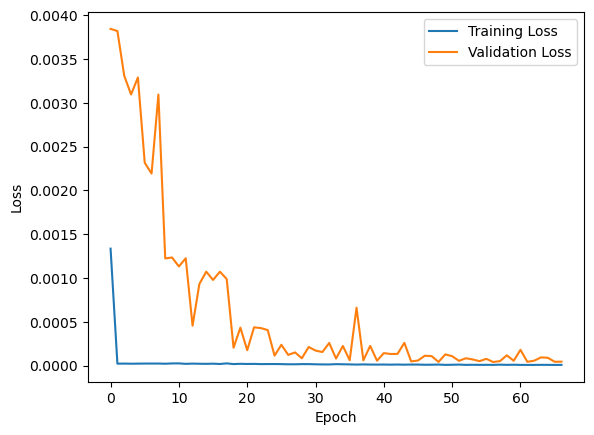

In [298]:
# Визуализация обучения
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Этот код оценивает точность модели, используя несколько метрик, таких как средняя абсолютная ошибка (MAE), среднеквадратичная ошибка (MSE) и коэффициент детерминации (R²). Давайте рассмотрим его по шагам:

In [299]:
# Оценка точности модели
y_pred = model.predict(X_test)
y_val_inv = scaler_prices.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_prices.inverse_transform(y_pred)

mae = mean_absolute_error(y_val_inv, y_pred_inv)
mse = mean_squared_error(y_val_inv, y_pred_inv)
r2 = r2_score(y_val_inv, y_pred_inv)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step
MAE: 255.91434183983148
MSE: 137403.80743445593
R²: 0.9983337326855991


```
y_pred = model.predict(X_test)
```
* `model.predict(X_test)` используется для получения прогнозируемых значений цен на тестовом наборе данных.
```
y_val_inv = scaler_prices.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_prices.inverse_transform(y_pred)
```
* `scaler_prices.inverse_transform()` обратно масштабирует нормализованные прогнозируемые и истинные цены в их оригинальный диапазон цен.
```
mae = mean_absolute_error(y_val_inv, y_pred_inv)
mse = mean_squared_error(y_val_inv, y_pred_inv)
r2 = r2_score(y_val_inv, y_pred_inv)
```
* `mean_absolute_error()`, `mean_squared_error()` и `r2_score()` используются для вычисления MAE, MSE и R² соответственно.

```
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')
```
Эти строки выводят значения MAE, MSE и R².
Эти метрики помогают оценить производительность модели. Например, меньшее значение MAE и MSE указывает на лучшую точность модели, а значение R² близкое к 1 указывает на хорошую пригодность модели.


Этот код создает временные метки для тестовой выборки, чтобы их можно было использовать при визуализации прогнозов модели. Давайте разберем его:

In [300]:
# Временные метки для тестовой выборки
test_dates = data['time'][-len(true_prices):]

```
test_dates = data['time'][-len(true_prices):]
```
* `data['time']` используется для получения временных меток из исходного набора данных.
* `[-len(true_prices):]` используется для выбора последних временных меток, соответствующих длине массива истинных цен. Таким образом, мы выбираем временные метки, соответствующие тестовому набору данных.

Это позволяет сохранить временные метки для тестового набора данных и использовать их при визуализации прогнозов модели на временном графике.

Этот код использует обученную модель для прогнозирования цены на следующий временной шаг, основываясь на последних 60 днях данных. Давайте разберем его:

In [301]:
# Прогнозирование цены
last_60_days = scaled_data[-60:]
next_pred = model.predict(np.array([last_60_days]))
next_pred = scaler_prices.inverse_transform(next_pred)

print(f"Прогнозируемая цена: {next_pred[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Прогнозируемая цена: 65329.72265625


```
last_60_days = scaled_data[-60:]
```
* `scaled_data[-60:]` выбирает последние 60 дней данных, чтобы использовать их в качестве входных данных для прогнозирования следующей цены.
```
next_pred = model.predict(np.array([last_60_days]))
```
* `model.predict(np.array([last_60_days]))` используется для прогнозирования следующей цены на основе последних 60 дней данных. Обратите внимание, что данные должны быть переданы в виде трехмерного массива, поэтому мы используем `np.array([last_60_days])`.
```
next_pred = scaler_prices.inverse_transform(next_pred)
```
* `scaler_prices.inverse_transform()` обратно масштабирует нормализованный прогноз цены в оригинальный диапазон цен.
```
print(f"Прогнозируемая цена: {next_pred[0][0]}")
```
* Эта строка выводит прогнозируемую цену на следующий временной шаг.

Этот код позволяет прогнозировать будущие цены на основе текущих данных и оценки модели.

Этот код создает интерактивный график, на котором отображаются истинные цены, предсказанные цены и прогнозируемая цена на следующий временной шаг. Давайте разберем его:

In [302]:
# Создание интерактивного графика
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_dates,
    y=true_prices.flatten(),
    mode='lines',
    name='Истинные цены',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_dates,
    y=predicted_prices.flatten(),
    mode='lines',
    name='Предсказанные',
    line=dict(color='red')
))

# Добавление прогноза на следующий день на график
fig.add_trace(go.Scatter(
    x=[test_dates.iloc[-1] + pd.Timedelta(hours=1)],  # дата следующего часа
    y=next_pred.flatten(),
    mode='markers',
    name='Прогнозируемая цена',
    marker=dict(color='green', size=10)
))

fig.update_layout(
    title='Прогнозирование цен на акции',
    xaxis_title='Дата и время',
    yaxis_title='Цена',
    hovermode='x'
)

# Отображение графика
fig.show()

```
fig = go.Figure()
```
* `go.Figure()` создает новый объект графика Plotly.
```
fig.add_trace(go.Scatter(
    x=test_dates,
    y=true_prices.flatten(),
    mode='lines',
    name='Истинные цены',
    line=dict(color='blue')
))
```
* `fig.add_trace()` добавляет линейный график истинных цен на график. mode='lines' указывает, что это линейный график. `true_prices.flatten()` используется для преобразования массива истинных цен в одномерный массив.
```
fig.add_trace(go.Scatter(
    x=test_dates,
    y=predicted_prices.flatten(),
    mode='lines',
    name='Предсказанные',
    line=dict(color='red')
))
```
* Аналогично добавляется линейный график предсказанных цен.
```
fig.add_trace(go.Scatter(
    x=[test_dates.iloc[-1] + pd.Timedelta(hours=1)],  # дата следующего часа
    y=next_pred.flatten(),
    mode='markers',
    name='Прогнозируемая цена',
    marker=dict(color='green', size=10)
))
```
* `fig.add_trace()` добавляет маркер на график для прогнозируемой цены на следующий временной шаг. Мы используем дату следующего часа `(test_dates.iloc[-1] + pd.Timedelta(hours=1))` и прогнозируемую цену `(next_pred.flatten())`.
```
fig.update_layout(
    title='Прогнозирование цен на акции',
    xaxis_title='Дата и время',
    yaxis_title='Цена',
    hovermode='x'
)
```
* `fig.update_layout()` используется для настройки параметров компоновки графика, таких как заголовок, подписи осей и режим взаимодействия при наведении мыши `(hovermode='x')`.
```
fig.show()
```
* `fig.show()` отображает график.

Этот график позволяет визуализировать истинные цены, предсказанные цены и прогнозируемую цену на следующий временной шаг, что помогает оценить производительность модели.

In [303]:
# Простая торговая стратегия
current_price = true_prices[-1][0]
predicted_price = next_pred[0][0]

signal = ''
if predicted_price > current_price:
    print("Сигнал на покупку")
elif predicted_price < current_price:
    print("Сигнал на продажу")
else:
    print("Сигнал удерживать позицию")

Сигнал на продажу


In [304]:
# Создание интерактивного графика
fig = go.Figure()

fig.add_trace(go.Scatter(x=data['time'], y=data['close'], mode='lines', name='Истинные цены', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=[data['time'].iloc[-1] + pd.Timedelta(hours=1)], y=[predicted_price], mode='markers', name='Прогнозируемая цена на следующий час', marker=dict(color='green', size=10)))

# Добавление аннотации с сигналом
fig.add_annotation(
    x=data['time'].iloc[-1] + pd.Timedelta(hours=1),
    y=predicted_price,
    text=signal,
    showarrow=True,
    arrowhead=1
)

# Добавление улучшенных меток времени при наведении курсора
fig.update_layout(
    title='Прогнозирование цен на акции',
    xaxis_title='Дата и время',
    yaxis_title='Цена',
    hovermode='x unified'
)

fig.update_traces(
    hovertemplate='%{x|%Y-%m-%d %H:%M:%S}<br>Цена: %{y:.2f}'
)

fig.show()


Эти функции `save_scaler` и `load_scaler` предназначены для сохранения и загрузки масштабаторов данных. Вот как они работаю

In [305]:
# Функции для сохранения и загрузки масштабаторов
def save_scaler(scaler, filename):
    joblib.dump(scaler, filename)

def load_scaler(filename):
    return joblib.load(filename)

```
def save_scaler(scaler, filename):
    joblib.dump(scaler, filename)
```
* `joblib.dump(scaler, filename)` используется для сохранения масштабатора scaler в файл с именем filename.
```
def load_scaler(filename):
    return joblib.load(filename)
```
* `joblib.load(filename)` используется для загрузки масштабатора из файла с именем `filename`. Функция возвращает загруженный масштабатор.

Эти функции могут быть полезны, если вы хотите сохранить масштабаторы данных для повторного использования при обработке новых данных или при переносе модели на другую платформу.

Теперь мы будем сохранять модель и масштабаторы в MongoDB, для этого нам понадобятся необходимые библиотеки для сохранения в необходимом формате в базе данных.

In [306]:
import gridfs
import pickle

In [307]:
# Подключение к MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['stock_data']
fs = gridfs.GridFS(db)

* `gridfs.GridFS(db)` создает объект `GridFS`, который позволяет хранить и извлекать большие файлы в базе данных `stock_data`.
* `GridFS` является расширением `MongoDB`, позволяющим хранить файлы, превышающие максимальный размер документа (16 MB), разбивая их на более мелкие части и распределяя по различным коллекциям.

In [308]:
# Сохранение модели в формате .keras
model_path = '/data/stock_prediction_model.keras'
model.save(model_path)

# Чтение модели как бинарных данных и сохранение в GridFS
with open(model_path, 'rb') as model_file:
    model_data = model_file.read()
fs.put(model_data, filename='stock_prediction_model.keras')
print("Model saved to MongoDB GridFS as 'stock_prediction_model.keras'")


Model saved to MongoDB GridFS as 'stock_prediction_model.keras'


Этот код сохраняет обученную модель в формате .keras, затем читает файл модели как бинарные данные и сохраняет их в GridFS, что позволяет хранить большие файлы в MongoDB.
* `model.save(model_path)` сохраняет модель в файл с именем `stock_prediction_model.keras` по указанному пути /data/.
* `fs.put(model_data, filename='stock_prediction_model.keras')` загружает содержимое файла модели в `GridFS` и сохраняет его с именем `stock_prediction_model.keras`.

In [309]:
# Функция для сохранения масштабаторов
def save_scaler(scaler, filename):
    with open(filename, 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)

# Пути к файлам масштабаторов
scaler_files = {
    'scaler_prices.pkl': scaler_prices,
    'scaler_rsi.pkl': scaler_rsi,
    'scaler_moving_avg_rsi.pkl': scaler_moving_avg_rsi
}

# Сохранение масштабаторов и загрузка в GridFS
for filename, scaler in scaler_files.items():
    save_scaler(scaler, f'/data/{filename}')
    with open(f'/data/{filename}', 'rb') as scaler_file:
        scaler_data = scaler_file.read()
    fs.put(scaler_data, filename=filename)
    print(f"Scaler saved to MongoDB GridFS as '{filename}'")


Scaler saved to MongoDB GridFS as 'scaler_prices.pkl'
Scaler saved to MongoDB GridFS as 'scaler_rsi.pkl'
Scaler saved to MongoDB GridFS as 'scaler_moving_avg_rsi.pkl'


Загрузка модели и масштабаторов из MongoDB
Чтобы загрузить сохраненную модель и масштабаторы, можно использовать следующий код:

In [310]:
from keras.optimizers import RMSprop

# Загрузка модели из GridFS
model_file = fs.find_one({'filename': 'stock_prediction_model.keras'})
with open('loaded_model.keras', 'wb') as f:
    f.write(model_file.read())
model = load_model('loaded_model.keras', compile=False)
print("Model loaded from MongoDB GridFS")

# Пересоздание оптимизатора
optimizer = RMSprop(learning_rate=0.001)

# Компиляция модели с новым оптимизатором
model.compile(optimizer=optimizer, loss='mean_squared_error')
print("Model recompiled with new optimizer")

# Загрузка масштабаторов из GridFS
def load_scaler(filename):
    scaler_file = fs.find_one({'filename': filename})
    with open(f'loaded_{filename}', 'wb') as f:
        f.write(scaler_file.read())
    with open(f'loaded_{filename}', 'rb') as f:
        scaler = pickle.load(f)
    return scaler

scaler_prices = load_scaler('scaler_prices.pkl')
scaler_rsi = load_scaler('scaler_rsi.pkl')
scaler_moving_avg_rsi = load_scaler('scaler_moving_avg_rsi.pkl')
print("Scalers loaded from MongoDB GridFS")



Model loaded from MongoDB GridFS
Model recompiled with new optimizer
Scalers loaded from MongoDB GridFS


In [456]:

def download_data(api_url, params):
    response = requests.get(api_url, params=params)
    data = response.json()
    return pd.DataFrame(data)


api_url = 'https://api.binance.com/api/v3/klines'
params = {
    'symbol': 'BTCUSDT',
    'interval': '1h',
    'limit': 10000
}

file_path = 'data/BIN3.csv'
new_data = download_data(api_url, params)
new_data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
new_data['time'] = pd.to_datetime(new_data['time'], unit='ms')

In [457]:
new_data.sort_values('time').tail()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
995,2024-06-17 14:00:00,65200.00000000,65790.00000000,65130.00000000,65472.98000000,1382.34399000,1718636399999,90518465.04881990,106624,752.71570000,49292823.44654360,0
996,2024-06-17 15:00:00,65472.98000000,65788.73000000,65239.97000000,65368.00000000,1356.80458000,1718639999999,88851468.57426710,74219,745.40364000,48833726.08080730,0
997,2024-06-17 16:00:00,65368.00000000,66056.65000000,65138.00000000,65898.00000000,2064.83382000,1718643599999,135472798.16486920,112375,981.36617000,64425040.33057450,0
998,2024-06-17 17:00:00,65898.01000000,66607.28000000,65898.00000000,66607.28000000,1936.55029000,1718647199999,128359646.74370590,84900,1103.31816000,73146477.90571840,0
999,2024-06-17 18:00:00,66607.27000000,67298.81000000,66550.03000000,66929.99000000,2780.93404000,1718650799999,186144961.33851060,110163,1503.65667000,100630768.79058360,0


In [458]:
def calculate_rsi(new_data, column='close', window=14):
    delta = new_data[column].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [459]:
def calculate_moving_avg_rsi(rsi, window=14):
    moving_avg_rsi = rsi.rolling(window=window, min_periods=1).mean()
    return moving_avg_rsi

In [460]:
columns_to_convert = ['open', 'high', 'low', 'close', 'volume']
for column in columns_to_convert:
    new_data[column] = pd.to_numeric(new_data[column], errors='coerce')

In [461]:
new_data['rsi'] = calculate_rsi(new_data)
new_data['moving_avg_rsi'] = calculate_moving_avg_rsi(new_data['rsi'])

In [462]:
# Выбираем необходимые столбцы и убираем пропуски
new_data = new_data[['time', 'close', 'rsi', 'moving_avg_rsi']].dropna()
new_data.tail(20)

,time,close,rsi,moving_avg_rsi
980,2024-06-16 23:00:00,66676.87,57.524584,64.346529
981,2024-06-17 00:00:00,66583.96,45.758258,61.551977
982,2024-06-17 01:00:00,66472.26,49.289862,60.315873
983,2024-06-17 02:00:00,66344.02,41.390438,58.449187
984,2024-06-17 03:00:00,66222.00,31.087332,55.596913
985,2024-06-17 04:00:00,66447.88,47.479664,54.536228
986,2024-06-17 05:00:00,66351.62,36.254377,52.376148
987,2024-06-17 06:00:00,66132.40,33.723211,50.278280
988,2024-06-17 07:00:00,66172.00,35.880905,48.376306
989,2024-06-17 08:00:00,66194.51,36.346627,46.520108


In [463]:
# Преобразование данных в numpy массивы
prices = new_data['close'].values.reshape(-1, 1)
rsi = new_data['rsi'].values.reshape(-1, 1)
moving_avg_rsi = new_data['moving_avg_rsi'].values.reshape(-1, 1)

In [464]:
# Нормализация данных
scaler_prices = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler_prices.fit_transform(prices)
scaler_rsi = MinMaxScaler(feature_range=(0, 1))
scaled_rsi = scaler_rsi.fit_transform(rsi)
scaler_moving_avg_rsi = MinMaxScaler(feature_range=(0, 1))
scaled_moving_avg_rsi = scaler_moving_avg_rsi.fit_transform(moving_avg_rsi)

In [465]:
# Объединение признаков в один массив
scaled_data = np.hstack((scaled_prices, scaled_rsi, scaled_moving_avg_rsi))

In [466]:
# Создание входных данных для модели
last_60_days = scaled_data[-60:]
new_data_for_prediction = np.vstack((last_60_days, scaled_data))

In [467]:
# Предсказание цены
next_hour_pred = model.predict(np.array([new_data_for_prediction[-60:]]))
next_hour_pred = scaler_prices.inverse_transform(next_hour_pred)

print(f"Прогнозируемая цена: {next_hour_pred[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Прогнозируемая цена: 65936.265625


In [468]:
# Простая торговая стратегия
current_price = prices[-1][0]
predicted_price = next_hour_pred[0][0]

signal = ""
if predicted_price > current_price:
    signal = "Сигнал на покупку"
elif predicted_price < current_price:
    signal = "Сигнал на продажу"
else:
    signal = "Сигнал удерживать позицию"
print(signal)

Сигнал на продажу


In [470]:
# Создание интерактивного графика
fig = go.Figure()

fig.add_trace(go.Scatter(x=new_data['time'], y=new_data['close'], mode='lines', name='Истинные цены', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=[new_data['time'].iloc[-1] + pd.Timedelta(hours=1)], y=[predicted_price], mode='markers', name='Прогнозируемая цена на следующий час', marker=dict(color='green', size=10)))

# Добавление аннотации с сигналом
fig.add_annotation(
    x=new_data['time'].iloc[-1] + pd.Timedelta(hours=1),
    y=predicted_price,
    text=signal,
    showarrow=True,
    arrowhead=1
)

# Добавление улучшенных меток времени при наведении курсора
fig.update_layout(
    title='Прогнозирование цен',
    xaxis_title='Дата и время',
    yaxis_title='Цена',
    hovermode='x unified'
)

fig.update_traces(
    hovertemplate='%{x|%Y-%m-%d %H:%M:%S}<br>Цена: %{y:.2f}'
)

fig.show()